In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-04-14 08:09:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.146.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   137MB/s    in 0.5s    

2021-04-14 08:09:08 (137 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# Load, preprocess and EDA

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cats_names = os.listdir(train_cats_dir)
train_dogs_names = os.listdir(train_dogs_dir)
validation_cats_names = os.listdir(validation_cats_dir)
validation_dogs_names = os.listdir(validation_dogs_dir)

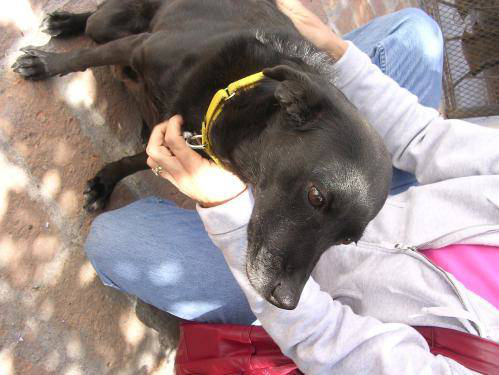

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
img = os.path.join(train_dogs_dir, train_dogs_names[10])
img = load_img(img)
img

Let's inspect the size, mode (colour/b&w..) and type (jpg, jpeg...)

In [ ]:
print(type(img))
print(img.mode)
print(img.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
RGB
(499, 375)


In [ ]:
from numpy import asarray
asarray(img)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [103,  89,  78],
        [100,  86,  75],
        [ 96,  82,  71]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 96,  82,  71],
        [ 94,  80,  69],
        [ 92,  78,  67]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 95,  81,  70],
        [ 95,  81,  70],
        [ 95,  81,  70]],

       ...,

       [[255, 248, 255],
        [255, 250, 255],
        [255, 252, 253],
        ...,
        [185, 106, 128],
        [185, 106, 128],
        [185, 106, 128]],

       [[255, 248, 255],
        [255, 249, 255],
        [255, 250, 252],
        ...,
        [186, 107, 129],
        [186, 107, 129],
        [186, 107, 129]],

       [[255, 248, 255],
        [255, 249, 255],
        [255, 249, 251],
        ...,
        [183, 104, 126],
        [183, 104, 126],
        [183, 104, 126]]

In [ ]:
sets = [train_dogs_names, train_cats_names, validation_dogs_names, validation_cats_names]
for subset in sets:
  print(len(subset))

1000
1000
500
500


**Summary:**

- 2 directories (train, validation) with 2 folders each (cats and dogs).

- 1000 training dogs, 1000 training cats, 500 training dogs, 500 training cats

- Image format arond (500,400,3), not in range 0-1



# Build the model

Define and compile the model:

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

Let's build a preprocessor with **`ImageDataGenerator()`** and **`ImageDataGenerator.flow_from_directory()`**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100, # 2000 images = 20(batch_size) * 100 (steps_per_epoch)
    epochs=10,
    validation_data = validation_generator,
    validation_steps=50, # 20*50= 1000 images
    verbose=2
)

Epoch 1/10
100/100 - 104s - loss: 0.5788 - accuracy: 0.7005 - val_loss: 0.5883 - val_accuracy: 0.6860
Epoch 2/10
100/100 - 104s - loss: 0.5427 - accuracy: 0.7300 - val_loss: 0.5903 - val_accuracy: 0.6920
Epoch 3/10
100/100 - 104s - loss: 0.5047 - accuracy: 0.7525 - val_loss: 0.5656 - val_accuracy: 0.7030
Epoch 4/10
100/100 - 104s - loss: 0.4817 - accuracy: 0.7600 - val_loss: 0.5915 - val_accuracy: 0.7010
Epoch 5/10
100/100 - 103s - loss: 0.4475 - accuracy: 0.7975 - val_loss: 0.5847 - val_accuracy: 0.7020
Epoch 6/10
100/100 - 104s - loss: 0.4150 - accuracy: 0.8000 - val_loss: 0.5822 - val_accuracy: 0.6970
Epoch 7/10
100/100 - 103s - loss: 0.3870 - accuracy: 0.8295 - val_loss: 0.5411 - val_accuracy: 0.7290
Epoch 8/10
100/100 - 103s - loss: 0.3661 - accuracy: 0.8370 - val_loss: 0.5527 - val_accuracy: 0.7290
Epoch 9/10
100/100 - 103s - loss: 0.3468 - accuracy: 0.8455 - val_loss: 0.5514 - val_accuracy: 0.7300
Epoch 10/10
100/100 - 103s - loss: 0.3070 - accuracy: 0.8780 - val_loss: 0.5539 - 

## Check the accuracy and loss of the model

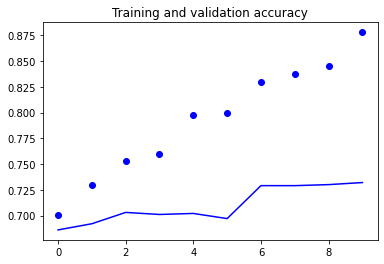

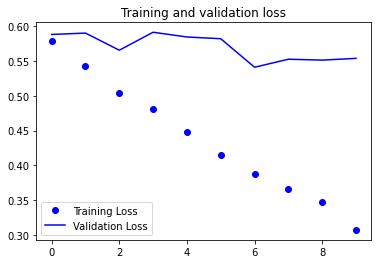

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Data Augmentation

In [19]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    metrics = 'accuracy',
    optimizer= RMSprop(lr=1e-4)
)

--2021-04-14 10:16:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   145MB/s    in 0.5s    

2021-04-14 10:16:52 (145 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(150,150),
  batch_size=20,
  class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
  validation_dir,
  target_size=(150,150),
  batch_size=20,
  class_mode='binary'
)

history = model.fit(
  train_generator,
  steps_per_epoch=100,
  epochs=10,
  validation_data = validation_generator,
  validation_steps=50,
  verbose=True
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 118s 1s/step - loss: 0.6952 - accuracy: 0.5295 - val_loss: 0.6865 - val_accuracy: 0.5580
Epoch 2/10
100/100 [==============================] - 117s 1s/step - loss: 0.6896 - accuracy: 0.5422 - val_loss: 0.6655 - val_accuracy: 0.5850
Epoch 3/10
100/100 [==============================] - 117s 1s/step - loss: 0.6681 - accuracy: 0.5913 - val_loss: 0.6540 - val_accuracy: 0.6170
Epoch 4/10
100/100 [==============================] - 116s 1s/step - loss: 0.6545 - accuracy: 0.6193 - val_loss: 0.6112 - val_accuracy: 0.6840
Epoch 5/10
100/100 [==============================] - 115s 1s/step - loss: 0.6290 - accuracy: 0.6379 - val_loss: 0.5997 - val_accuracy: 0.6930
Epoch 6/10
100/100 [==============================] - 114s 1s/step - loss: 0.6361 - accuracy: 0.6640 - val_loss: 0.6157 - val_accuracy: 0.6730
Epoch 7/10
100/100 [==============================] - 117s

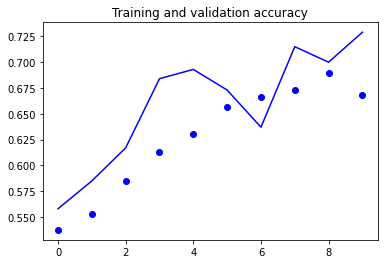

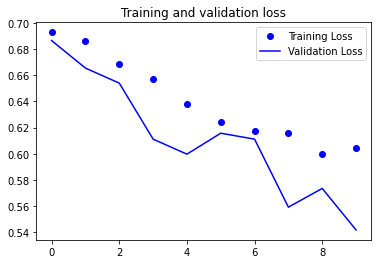

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()